In [1]:
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import sklearn.cluster as cluster
import umap

/home/daynaolson/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-19 16:01:56.117444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 16:01:56.663191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-19 16:01:56.663245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.

In [2]:
data = pd.read_csv("spot_feats.csv") #load data from merge_data.py output
data = data.dropna()

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

## Exp preprocessing Taken From: https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html#QC-and-preprocessing

# Clustering CLS Tokens
### CLS tokens derived from scDINO vision transformer and normalized to the spot level

/home/daynaolson/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/daynaolson/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


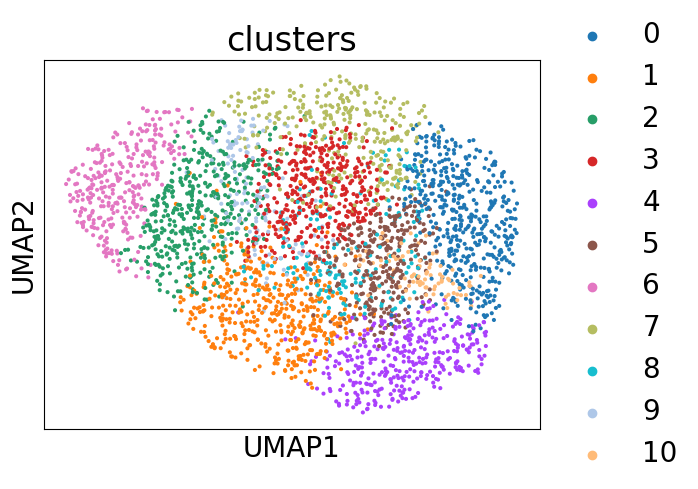

In [4]:
cls_vals = data.filter(regex='^i',axis=1)
cls = sc.AnnData(cls_vals)
sc.pp.pca(cls)
sc.pp.neighbors(cls)
sc.tl.umap(cls)
sc.tl.leiden(cls, key_added="clusters")
sc.pl.umap(cls, color=["clusters"], wspace=0.4)

# Clustering Gene Expression

/home/daynaolson/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/daynaolson/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


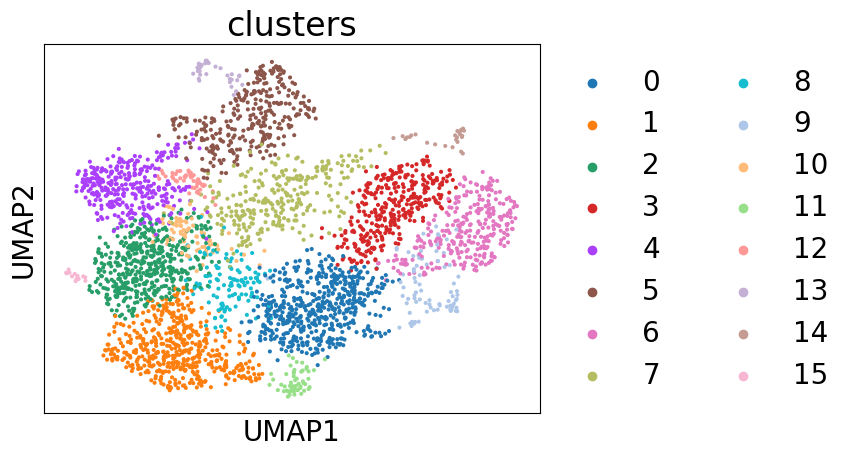

In [5]:
exp_vals = data.filter(regex='^e',axis=1)
exp = sc.AnnData(exp_vals)
sc.pp.filter_genes(exp, min_cells=10)
sc.pp.normalize_total(exp, inplace=True)
sc.pp.log1p(exp)
sc.pp.highly_variable_genes(exp, flavor="seurat", n_top_genes=2000)

sc.pp.pca(exp)
sc.pp.neighbors(exp)
sc.tl.umap(exp)
sc.tl.leiden(exp, key_added="clusters")

sc.pl.umap(exp, color=["clusters"], wspace=0.4)

# Clustering CLS Tokens + Gene Expression

/home/daynaolson/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/daynaolson/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/daynaolson/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


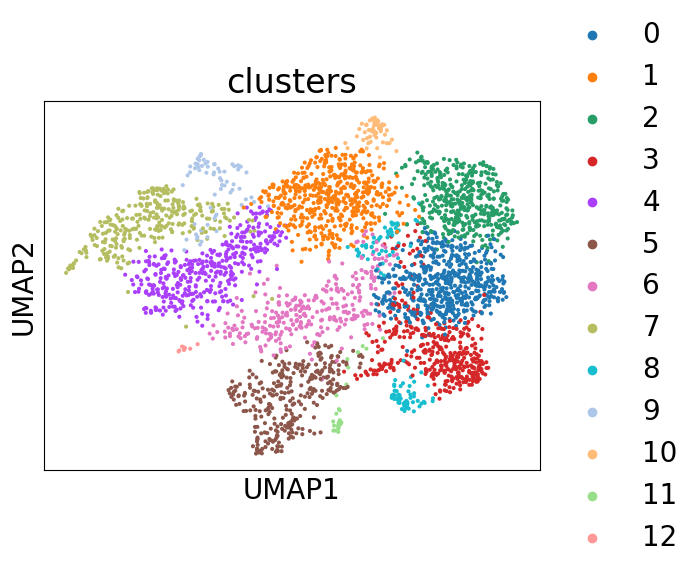

In [6]:
cls_new = sc.AnnData(cls_vals)

exp_new = sc.AnnData(exp_vals)
sc.pp.filter_genes(exp_new, min_cells=10)
sc.pp.normalize_total(exp_new, inplace=True)
sc.pp.log1p(exp_new)
sc.pp.highly_variable_genes(exp_new, flavor="seurat", n_top_genes=2000)

comb_vals = pd.concat([data.filter(regex='^i',axis=1), data.filter(regex='^e',axis=1)], axis=1)
comb = ad.concat([cls_new, exp_new], axis=1,join="inner") #only expression is pre-processed with scanpy

sc.pp.pca(comb)
sc.pp.neighbors(comb)
sc.tl.umap(comb)
sc.tl.leiden(comb, key_added="clusters")

sc.pl.umap(comb, color=["clusters"], wspace=0.4)

# Tissue Plotting

###  Spots plotted by tissue coordinates, colored by cluster 

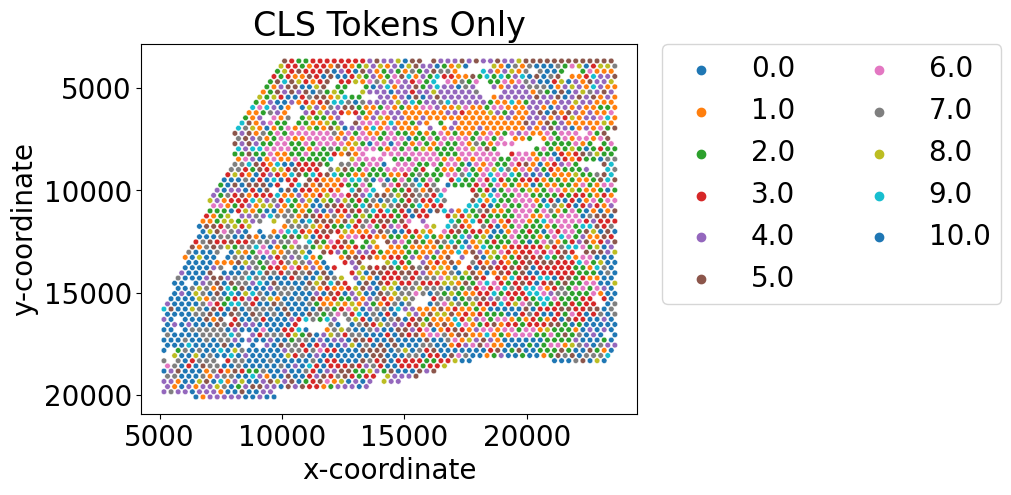

In [7]:
cls_df = pd.Series(np.array(cls.obs["clusters"],dtype="int"), name="clusters")
cls_tissue = pd.concat([data["pxl_row_in_fullres"],data["pxl_col_in_fullres"],cls_df], axis=1)
sns.scatterplot(x='pxl_col_in_fullres', y='pxl_row_in_fullres', data=cls_tissue, hue='clusters', palette='tab10', s=16)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title("CLS Tokens Only")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncols=2)
plt.show()

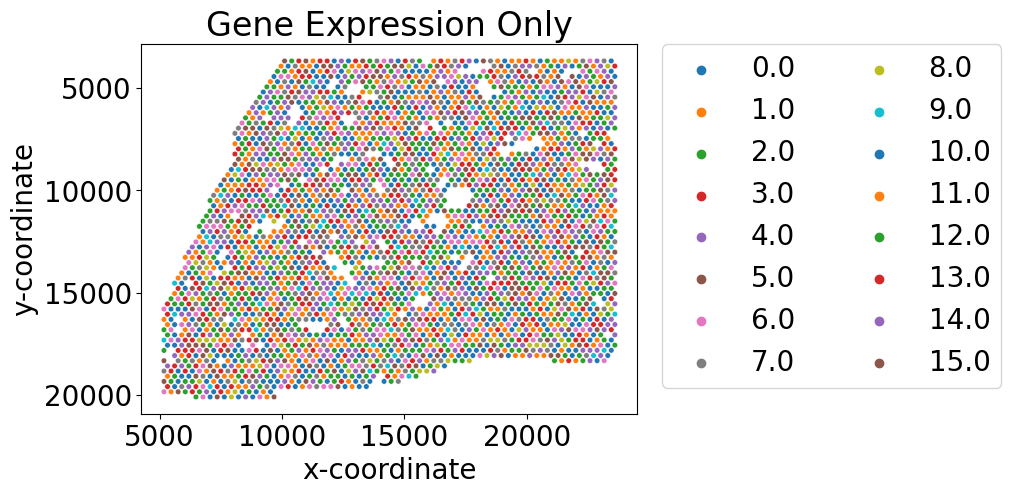

In [8]:
exp_df = pd.Series(np.array(exp.obs["clusters"],dtype="int"), name="clusters")
exp_tissue = pd.concat([data["pxl_row_in_fullres"],data["pxl_col_in_fullres"],exp_df], axis=1)
sns.scatterplot(x='pxl_col_in_fullres', y='pxl_row_in_fullres', data=exp_tissue, hue='clusters', palette='tab10', s=16)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title("Gene Expression Only")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncols=2)
plt.show()

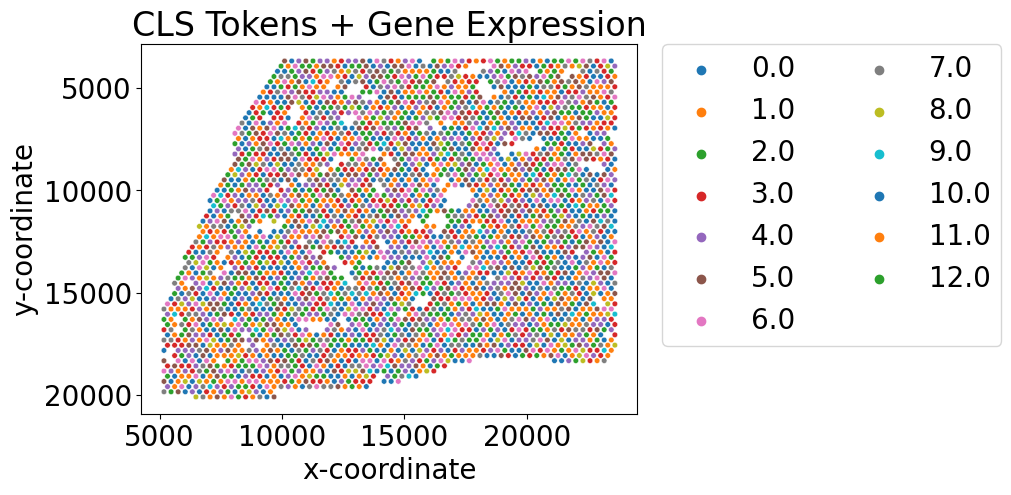

In [11]:
comb_df = pd.Series(np.array(comb.obs["clusters"],dtype="int"), name="clusters")
comb_tissue = pd.concat([data["pxl_row_in_fullres"],data["pxl_col_in_fullres"],comb_df], axis=1)
sns.scatterplot(x='pxl_col_in_fullres', y='pxl_row_in_fullres', data=comb_tissue, hue='clusters', palette='tab10', s=16,)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title("CLS Tokens + Gene Expression")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncols=2)
plt.show()